In [1]:
from glob import glob
from os.path import join, dirname

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
# import pingouin as pg

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55', '71', '72', '73', '74'
    , '75'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [5]:
list_run = ['r%02d'%(ii+1) for ii in range(3)]

In [6]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [7]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [8]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [9]:
dz = pd.concat([dx, dy])
del dx, dy
dz

,group
GA01,no_stim
GA35,no_stim
GA26,no_stim
GA02,no_stim
GA18,no_stim
...,...
GP71,DLPFC_20Hz
GP72,DLPFC_20Hz
GP73,DLPFC_20Hz
GP74,DLPFC_20Hz


In [10]:
list_group = dz.group.unique().astype(str)
list_group

array(['no_stim', 'M1_cTBS', 'DLPFC_cTBS', 'DLPFC_20Hz'], dtype='<U10')

---

In [11]:
p_thresh = 5.e-2
thresh = stats.norm.isf(0.5*p_thresh)

---

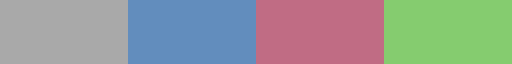

In [12]:
## labeling
# palette = cm.turbo(np.linspace(0.1,1.0,4))
palette = ['#A9A9A9', '#628dbd', '#C06C84', '#85cc6f']
cmap = colors.ListedColormap(palette)
cmap

In [13]:
view_cut = {}
view_cut['sagittal'] = [-55, -22, -7]
view_cut['axial'] = [2]

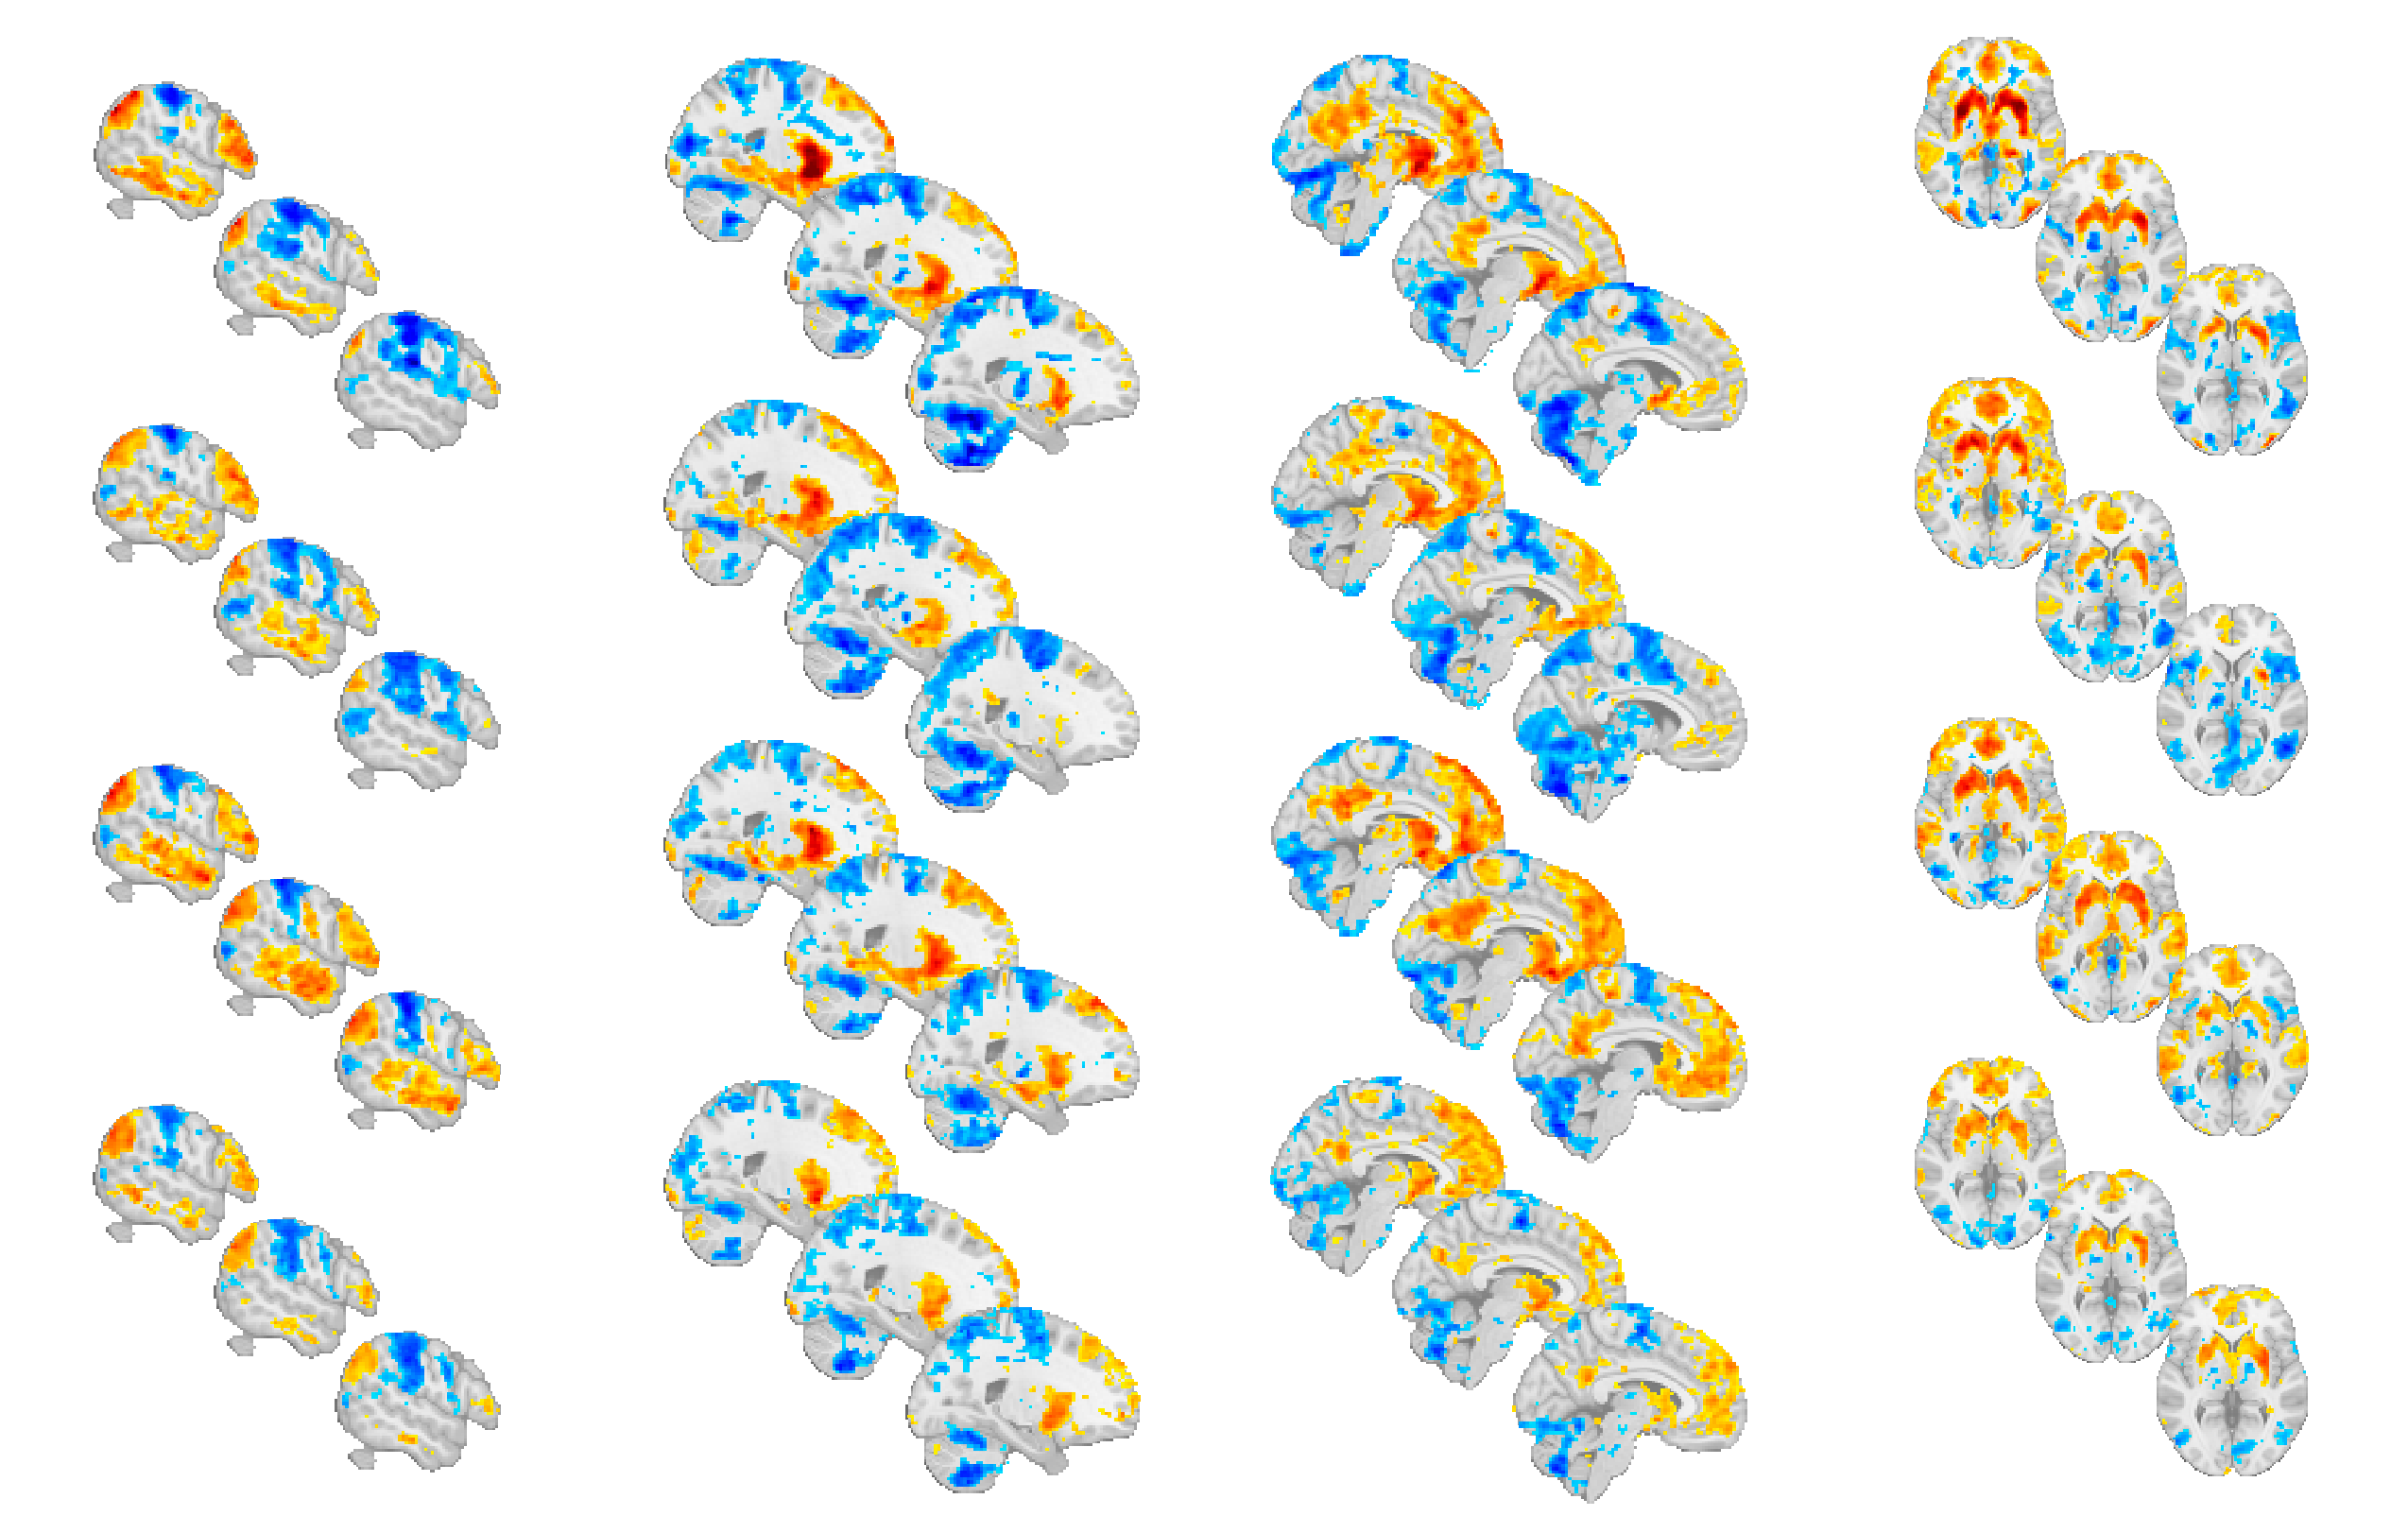

In [65]:
nrows, ncols = 4, 4
nruns = 3
w, h = 0.55, 0.55
fig, axs = plt.subplots(nrows=48, ncols=1)
# axs = np.concatenate(axs)
for row, group in enumerate(['no_stim', 'DLPFC_cTBS', 'M1_cTBS', 'DLPFC_20Hz']):
    for rr, run in enumerate(list_run):
        ## sagittal
        for col, coord in enumerate(view_cut['sagittal']):
            idx = rr + col*nruns + row*ncols*nruns
            ax = axs[idx]
            x = 1.0*col + 0.20*(rr+1)
            y = 2.2 - 0.75*row - 0.25*(rr+1)
            ax.set_position([x, y, w, h])
            
            if group =='no_stim':
                fname_Zscr = glob(join(
                    '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted/old'
                    , 'Zstat.%s.prac.n??.nii'%run
                ))[0]
            else:
                fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]

            img_stat = fname_Zscr
            
            g = plotting.plot_stat_map(
                img_stat,
                threshold=thresh,
                display_mode='x',
                black_bg=False,
                cut_coords=[coord], annotate=False,
                vmax=6.5,
                cmap='jet', colorbar=False,
                axes=ax,
            )
            # g.annotate(positions=True if run=='r01' else False, size=22 if run=='r01' else 0)
            # ax.text(0.5,0.5,'(%d,%d)'%(row+1,col+1))
            # for text in g.annotate_ax.texts:
            #     text.set_fontsize(20)
        
        ## axial
        for coord in view_cut['axial']:
            col = 3
            idx = rr + col*nruns + row*ncols*nruns
            ax = axs[idx]
            x = 1.0*col + 0.20*(rr+1)
            y = 2.2 - 0.75*row - 0.25*(rr+1)
            ax.set_position([x, y, w, h])

            img_stat = fname_Zscr
    
            g = plotting.plot_stat_map(
                img_stat,
                threshold=thresh,
                display_mode='z',
                black_bg=False,
                cut_coords=[coord], annotate=False,
                vmax=6.5,
                cmap='jet', colorbar=False,
                axes=ax
            )
            # g.annotate(positions=True if run=='r01' else False, size=22 if run!='r01' else 0)

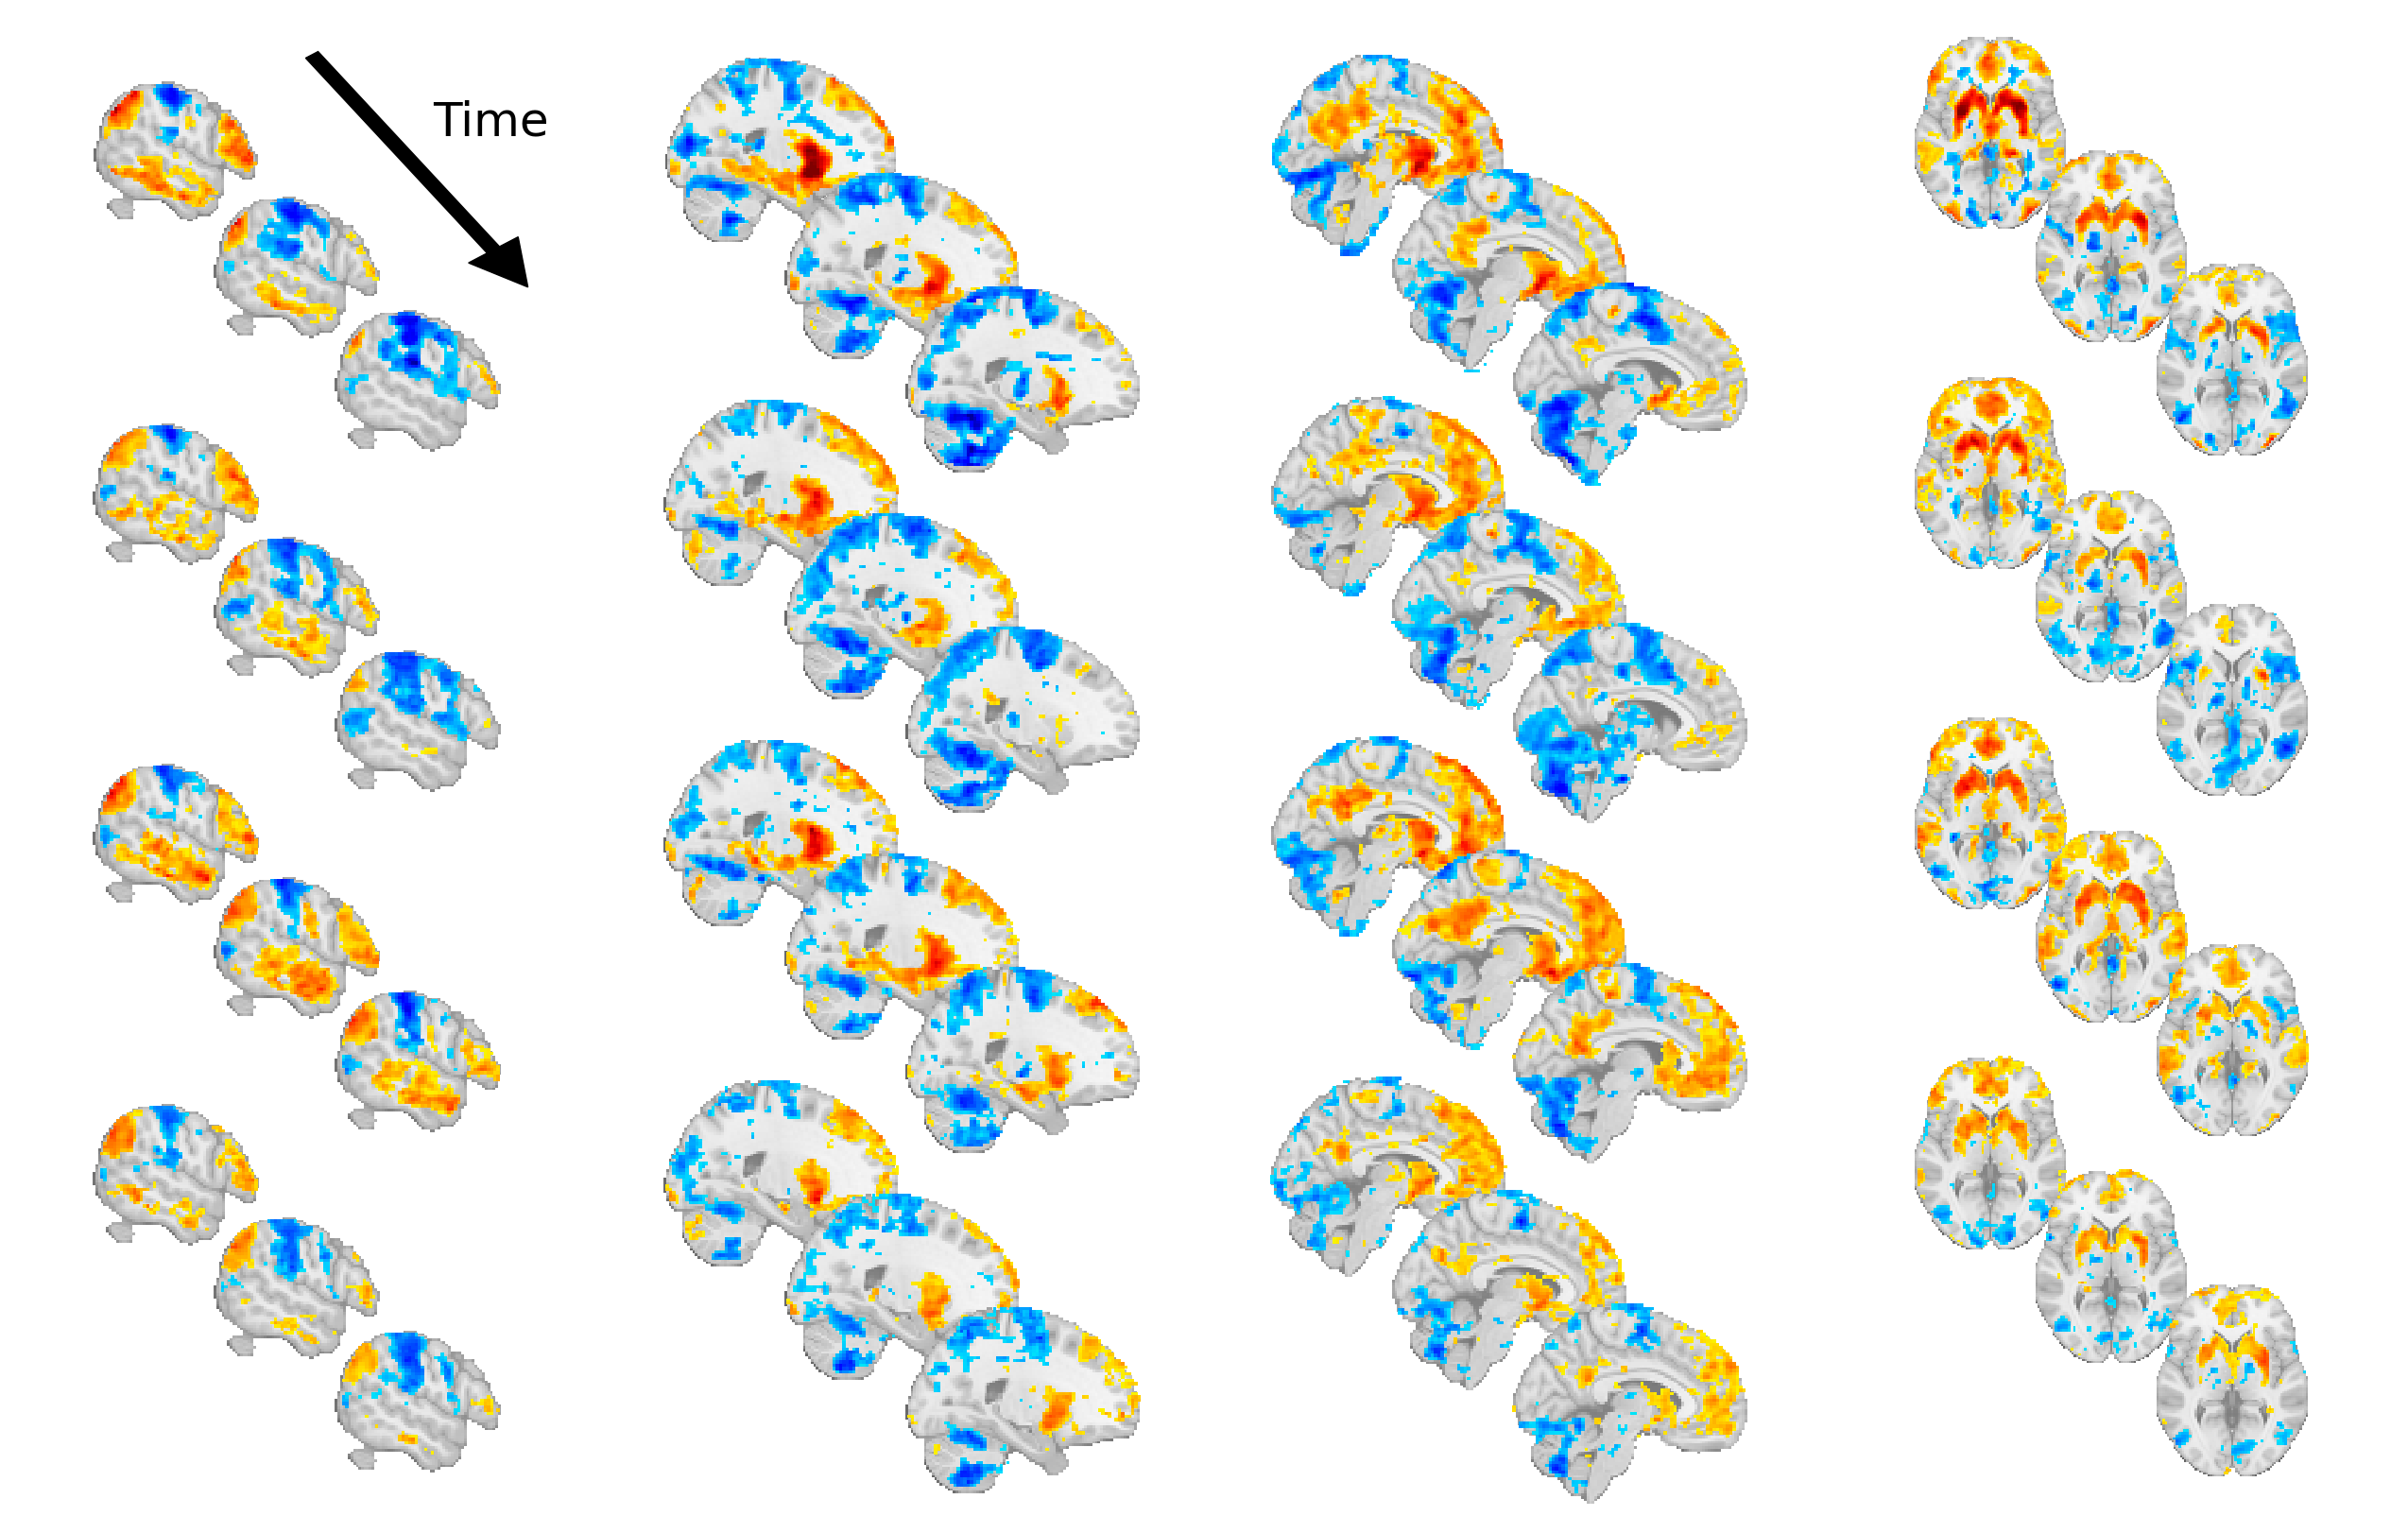

In [66]:
from matplotlib.patches import FancyArrow

## 화살표 삽입
# axs[1].annotate(
#     'Time', xy=(1, 0.4), xytext=(0.5, 1), fontsize=40,
#     arrowprops=dict(
#         facecolor='black', shrink=0.05,
#         width=6, headwidth=20, headlength=30
#     )
# )
arrow = FancyArrow(0.7, 2.4, 0.3, -0.43, width=0.025, head_width=0.10, head_length=0.10, color='black')
fig.add_artist(arrow)

fig.text(0.9, 2.25, 'Time', va='center', rotation='horizontal', fontsize=36)

fig

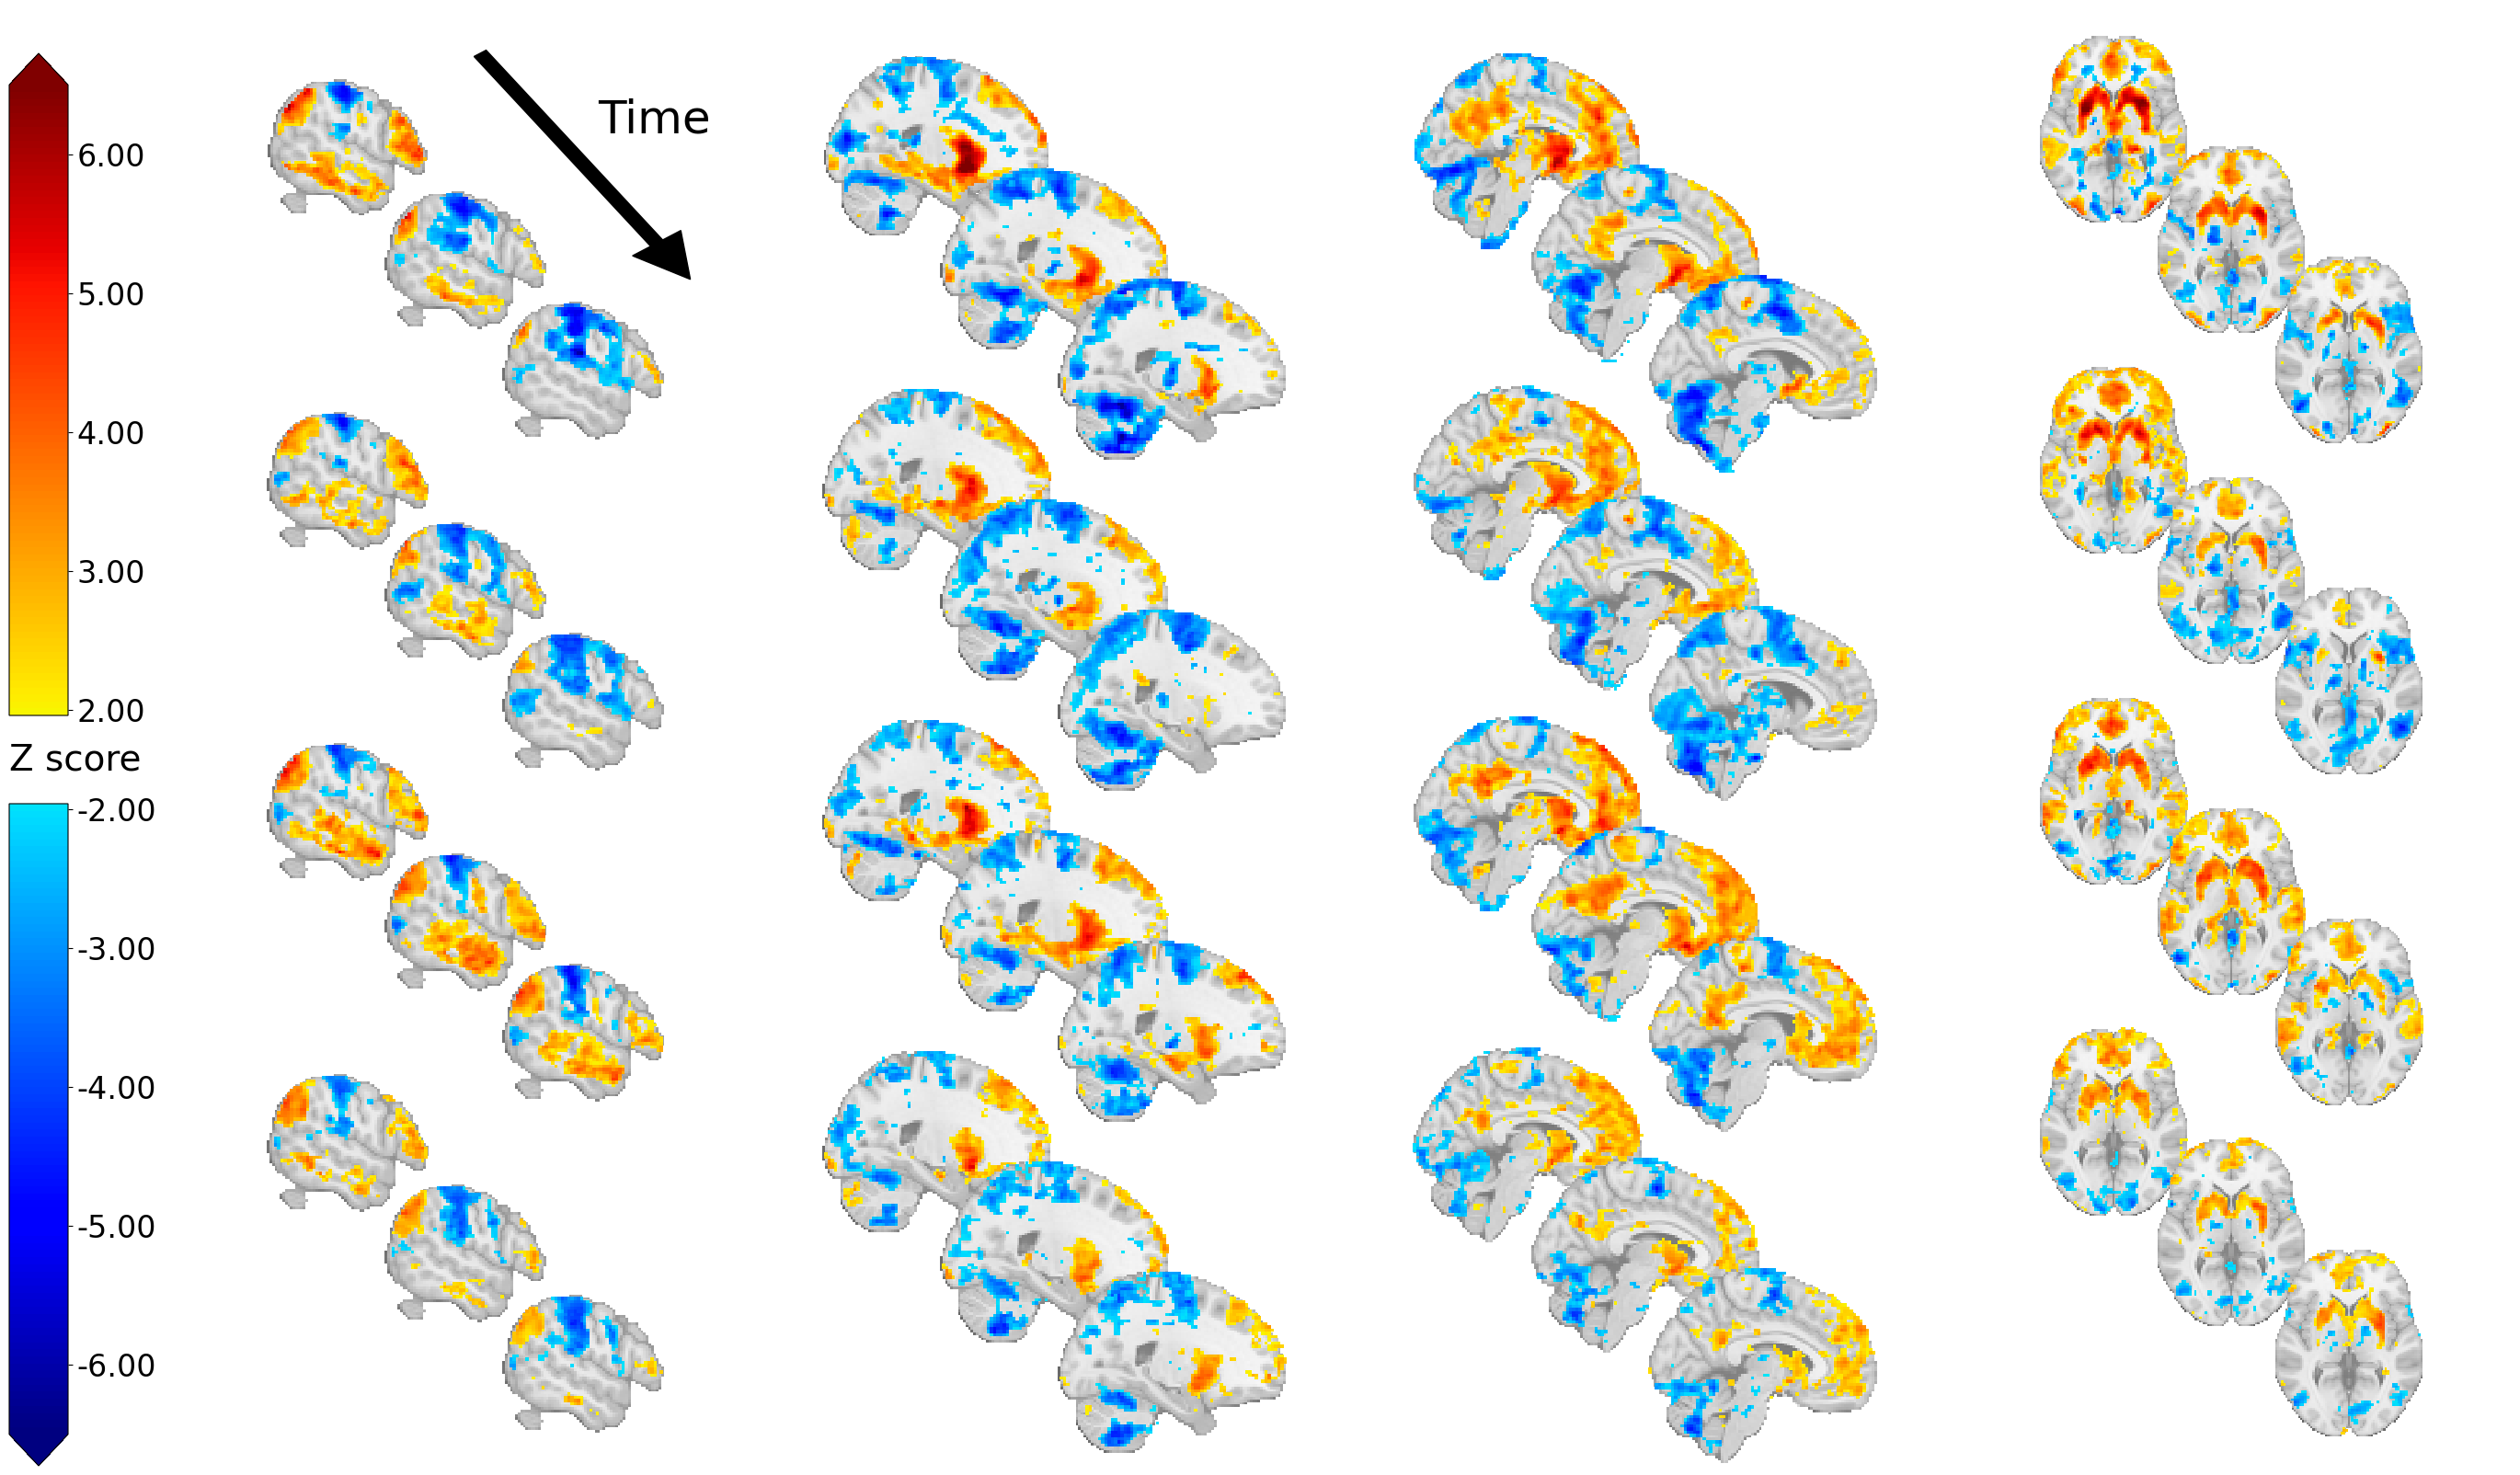

In [67]:
## 최대 최소 설정
vmax = 6.5
vmin = -6.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

################
## upper cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=vmax)
    , cmap=cmap_new
)
### 컬러바 삽입
cax = fig.add_axes([-0.1, 0.9, 0.1, 1.5])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)
cbar.ax.tick_params(labelsize=24)

################
## lower cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=vmin, vmax=-thresh)
    , cmap=cmap_new
)
### 컬러바 삽입
cax = fig.add_axes([-0.1, -0.8, 0.1, 1.5])
cbar = fig.colorbar(
    colormapping, extend='min'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax
)
cbar.ax.tick_params(labelsize=24)

fig.text(-0.1, 0.8, 'Z score', va='center', rotation='horizontal', fontsize=28)
fig

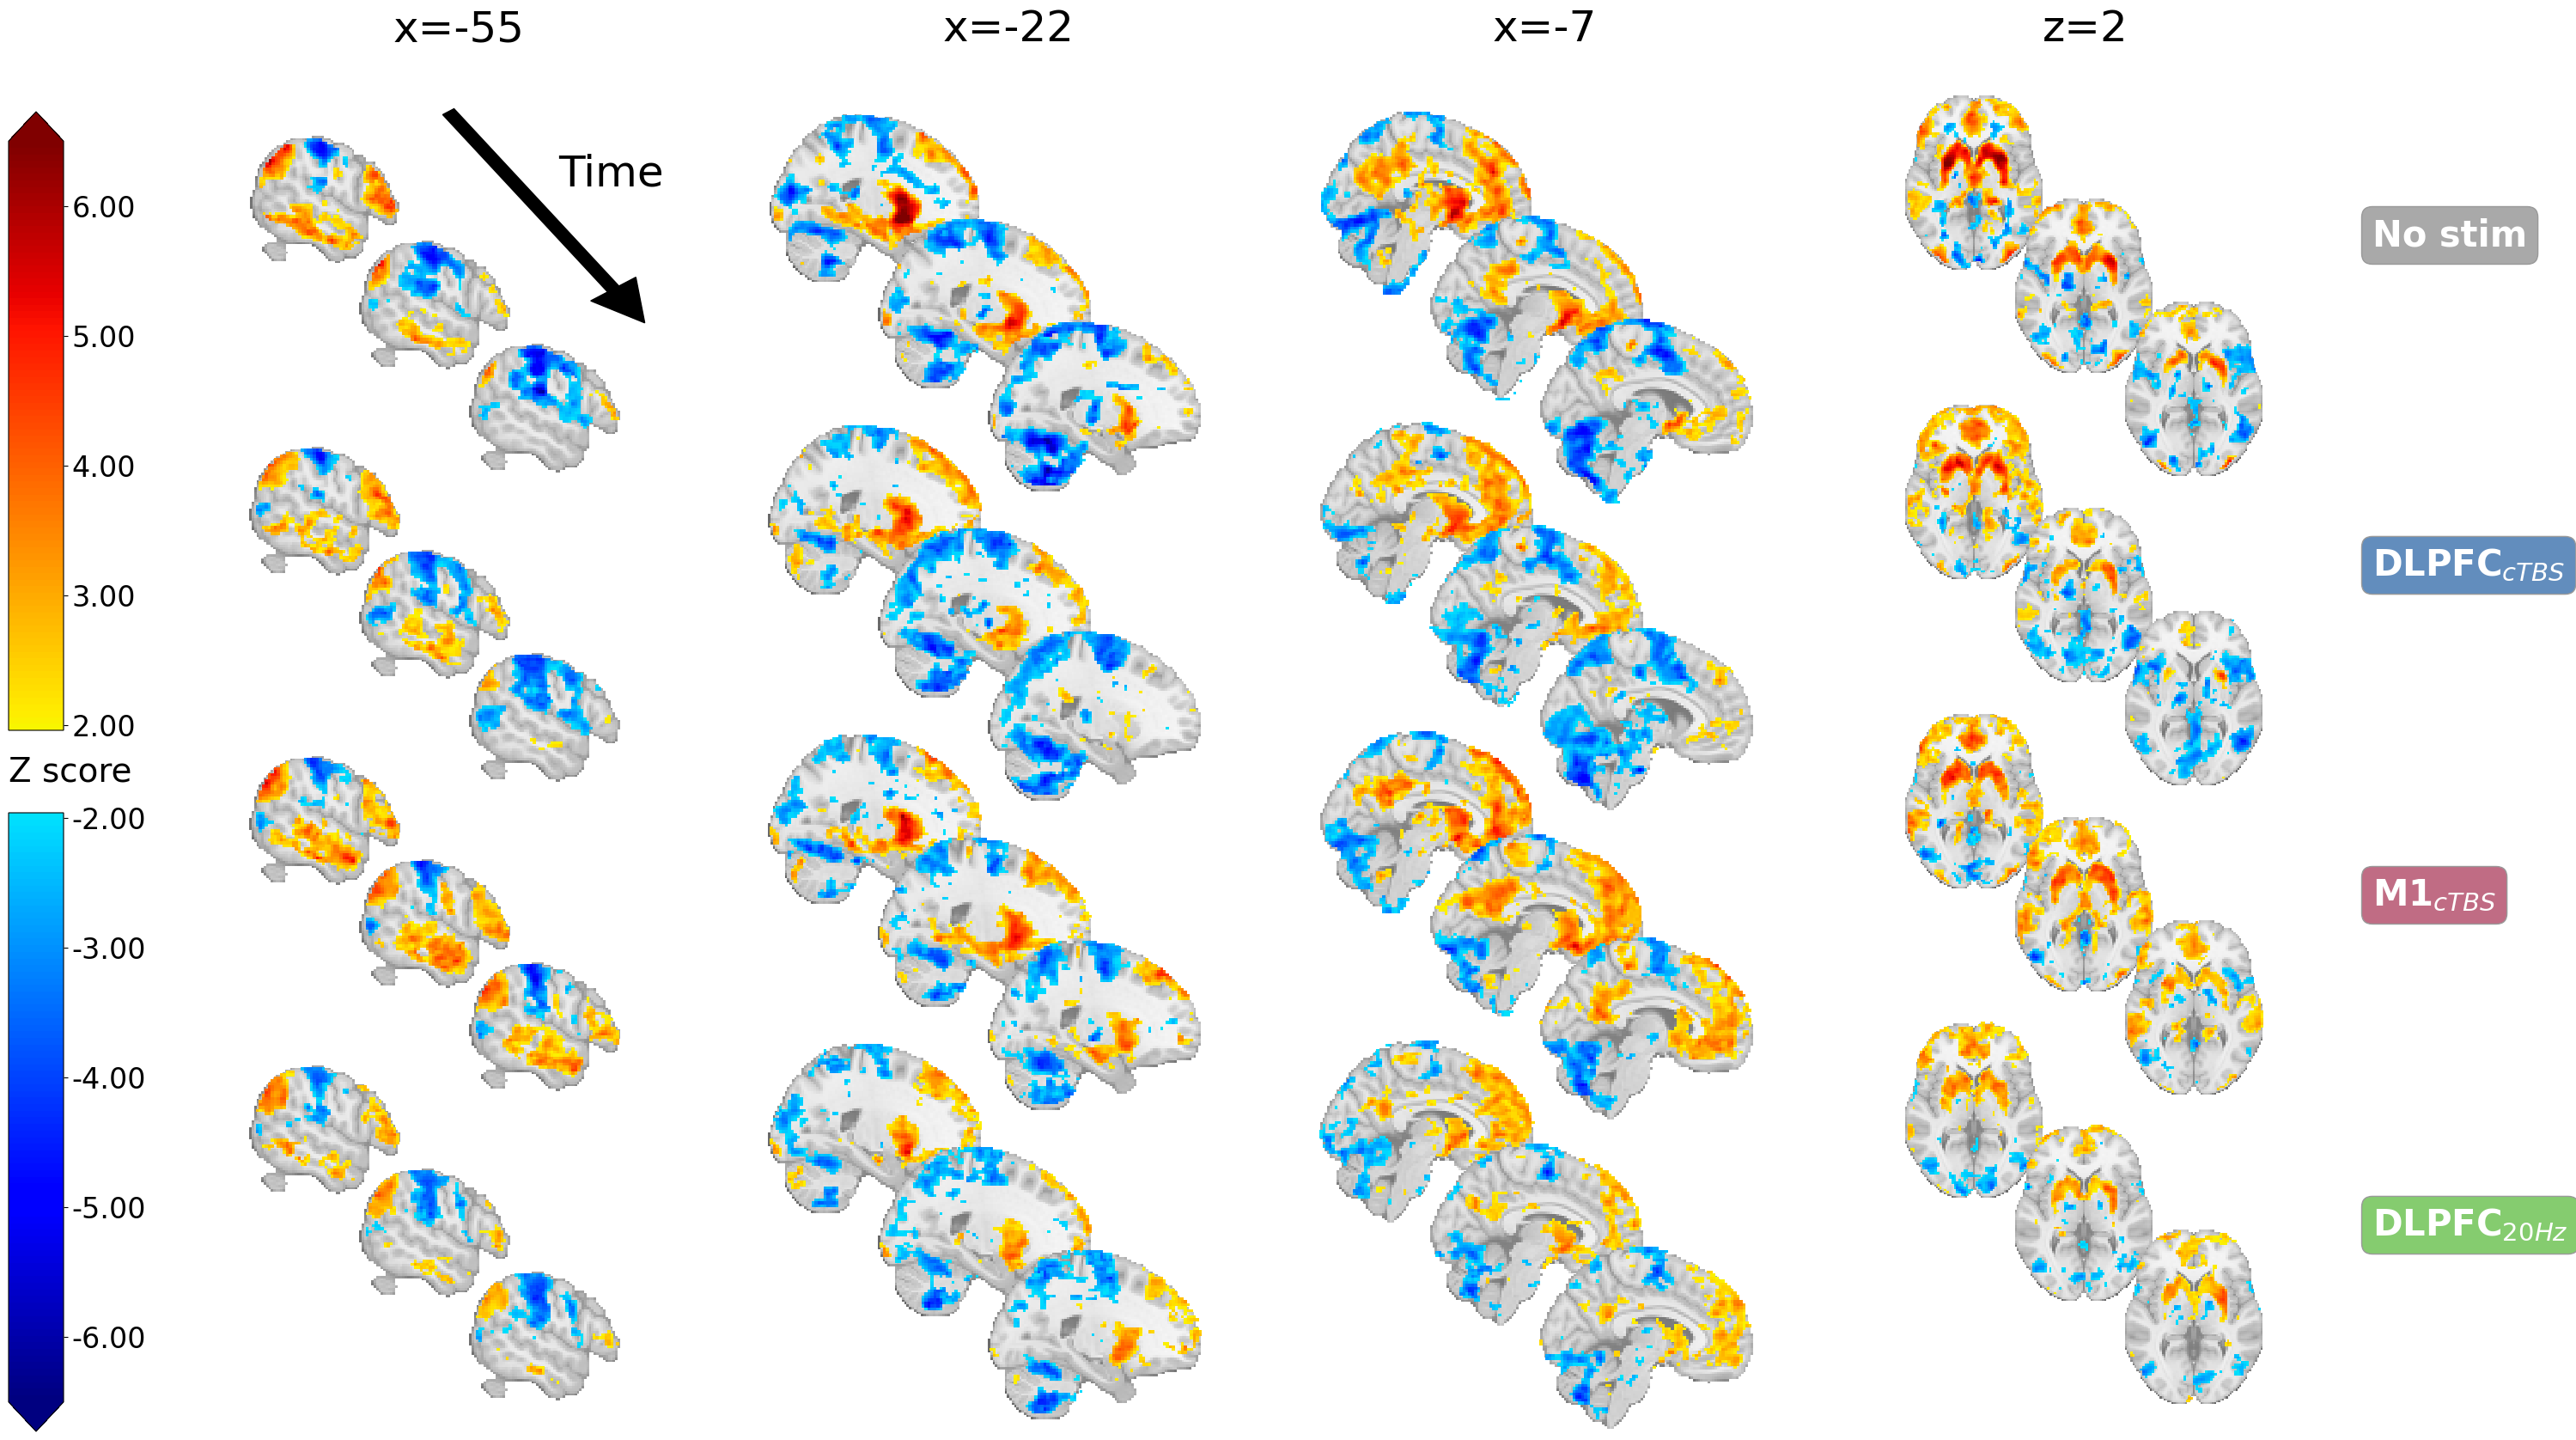

In [68]:
## labeling
dy = 0.8
## titles
for ii, group in enumerate(['No stim',r'DLPFC$_{cTBS}$',r'M1$_{cTBS}$',r'DLPFC$_{20Hz}$']):
    fig.text(
        4.2, 2.1-dy*ii, group
        , size=30, rotation=0
        , ha='left', va='center'
        , color='white', fontweight='bold'
        , bbox=dict(
            boxstyle='round'
            , ec=(0.6, 0.6, 0.6)
            , fc=palette[ii]
        )
    )

dx = 1
list_ = ['x=-55', 'x=-22', 'x=-7', 'z=2']
for col in range(4):
    fig.text(0.6+dx*col, 2.6, list_[col], va='center', rotation='horizontal', fontsize=36)

# fig.tight_layout()
fig

In [69]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fig.S3.png'
    , dpi=600, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

Zstat.r01.DLPFC_20Hz.n16.nii
Zstat.r01.DLPFC_cTBS.n17.nii
Zstat.r01.M1_cTBS.n17.nii
Zstat.r02.DLPFC_20Hz.n16.nii
Zstat.r02.DLPFC_cTBS.n17.nii
Zstat.r02.M1_cTBS.n17.nii
Zstat.r03.DLPFC_20Hz.n16.nii
Zstat.r03.DLPFC_cTBS.n17.nii
Zstat.r03.M1_cTBS.n17.nii


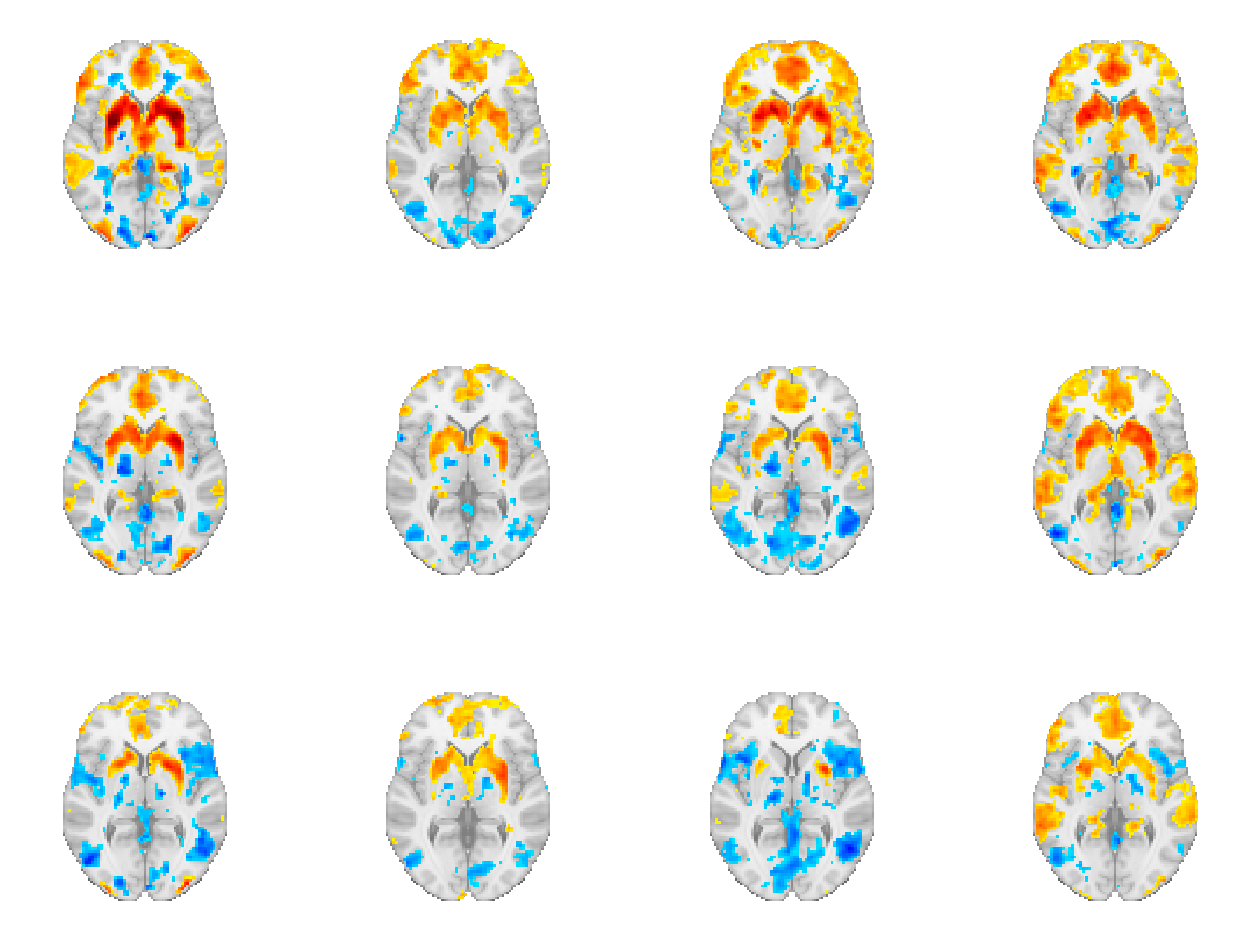

In [157]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,12))

for ii, fname in enumerate(sorted(glob(join(dir_stat.replace('GP','GA'),'old/Zstat.r??.prac.n??.nii')))):
    tmp = fname.split('/')[-1]
    run = tmp.split('.')[1]
    group = tmp.split('.')[2]
    ax = axs[ii][0]
    plotting.plot_stat_map(
        fname,
        threshold=thresh,
        display_mode='z', resampling_interpolation='continuous',
        black_bg=False,
#         annotate=True if run=='r01' else False,
        annotate=False,
        cut_coords=[2],
        vmax=6.5,
        cmap='jet', colorbar=False, symmetric_cbar=True,
        axes=ax
    )

for ii, fname in enumerate(sorted(glob(join(dir_stat,'Zstat.r0?.*.n??.nii')))):
    print(fname.split('/')[-1])
    run = fname.split('/')[-1].split('.')[1]
    ax = axs[ii//3][1+ii%3]
    plotting.plot_stat_map(
        fname,
        threshold=thresh,
        display_mode='z', resampling_interpolation='continuous',
        black_bg=False,
#         annotate=True if run=='r01' else False,
        annotate=False,
        cut_coords=[2],
        vmax=6.5,
        cmap='jet', colorbar=False, symmetric_cbar=True,
#         title=fname,
        axes=ax
    )
# fig.tight_layout()

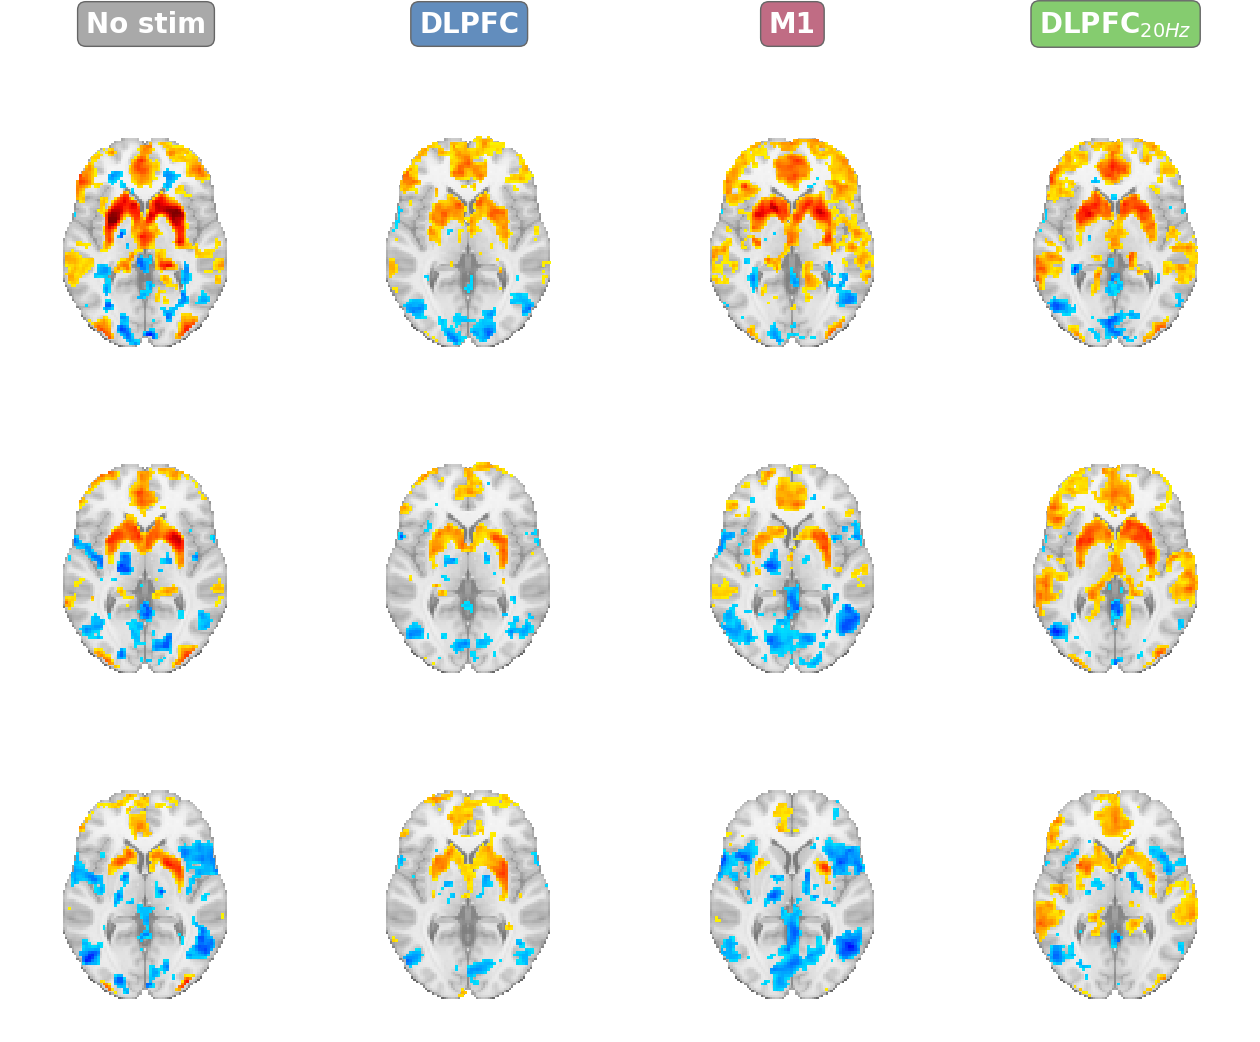

In [158]:
dx = 0.202
## titles
for ii, group in enumerate(['No stim',r'DLPFC',r'M1',r'DLPFC$_{20Hz}$']):
    fig.text(
        0.21+ dx*ii, 0.95, group
        , size=20, rotation=0
        , ha='center', va='center'
        , color='white', fontweight='bold'
        , bbox=dict(
            boxstyle='round'
            , ec=(0.4, 0.4, 0.4)
            , fc=palette[ii]
        )
    )
fig

/tmp/ipykernel_257821/3236999522.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


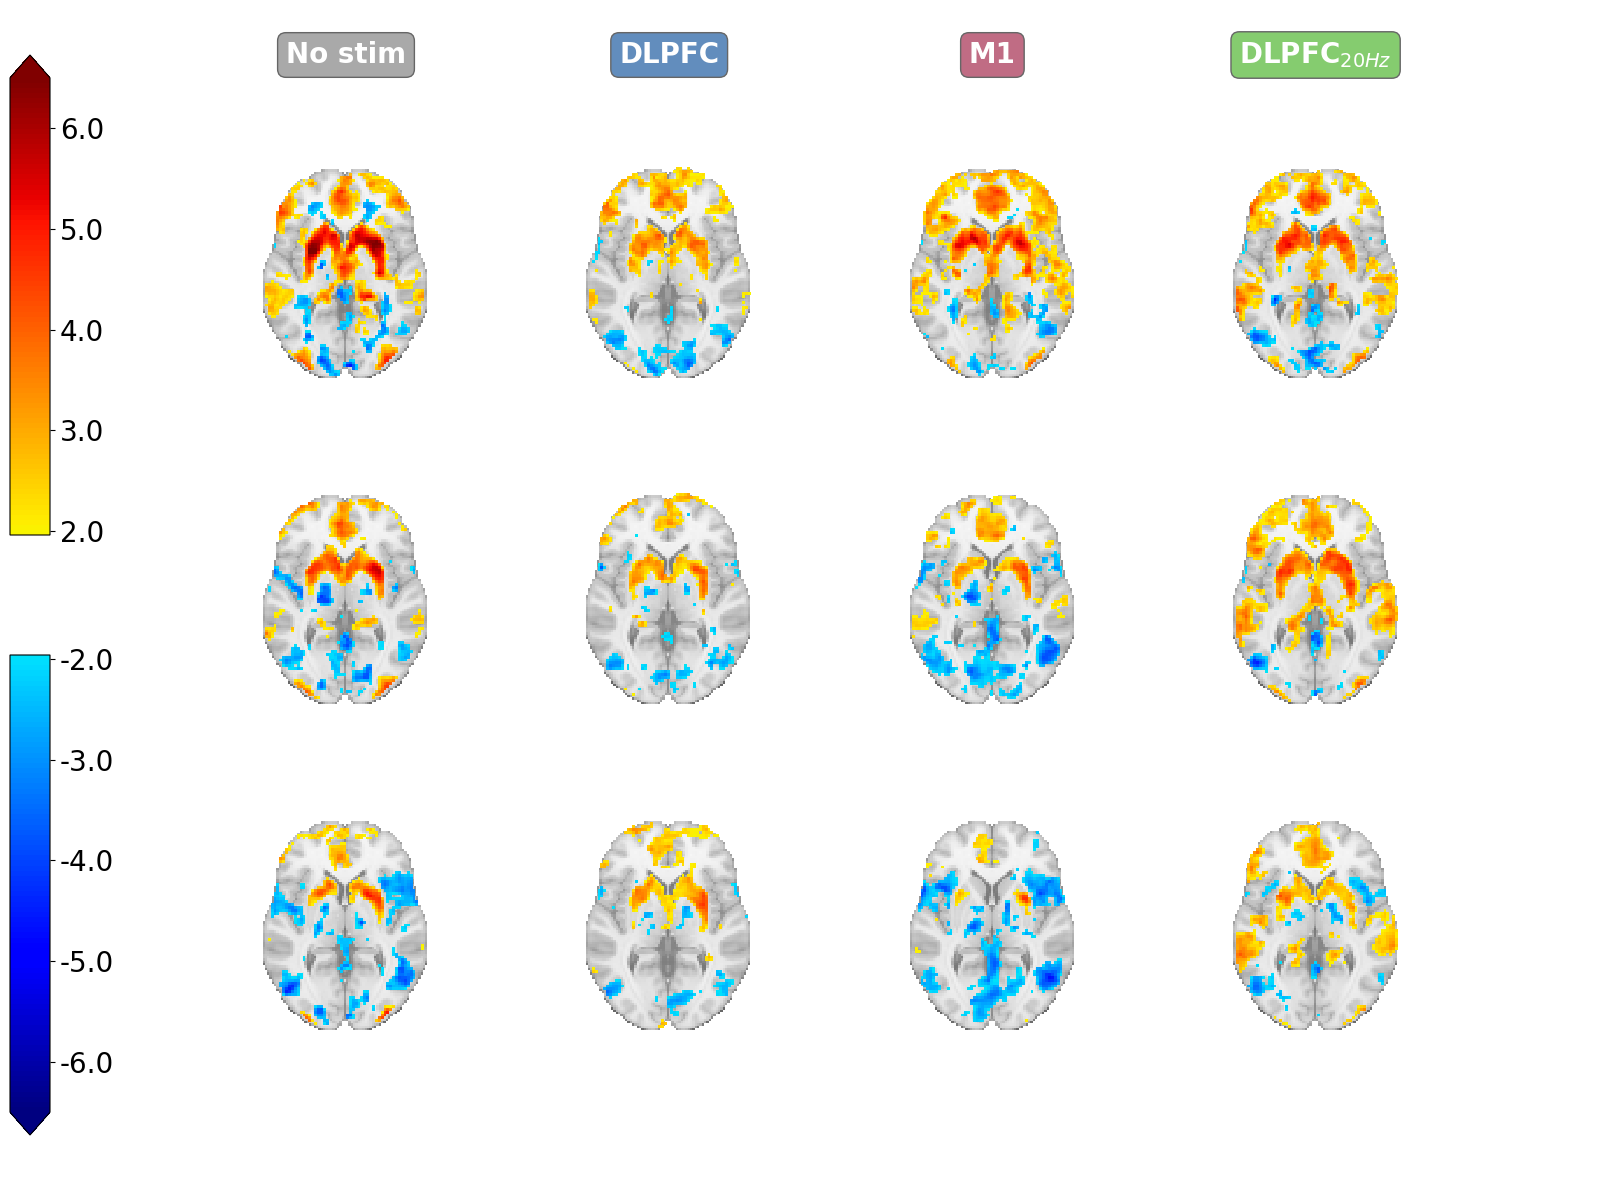

In [159]:
norm = colors.Normalize(vmin=-6.5, vmax=6.5)
## =============================================== ##    
### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=-6.5, vmax=-thresh), cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.0, -1., .025, 0.85])
cax = fig.add_axes([0., 0.05, .025, 0.4])
cbar = fig.colorbar(
    colormapping, extend='min',
    orientation='vertical',
    format='%.1f',
    cax=cax
)
cbar.ax.tick_params(labelsize=20)
## =============================================== ##    
### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=6.5), cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.0, 0., .025, 0.85])
cax = fig.add_axes([0.0, 0.55, .025, 0.4])
cbar = fig.colorbar(
    colormapping, extend='max', 
    orientation='vertical',
    format='%.1f',
    cax=cax
)
cbar.ax.tick_params(labelsize=20)
fig.tight_layout()
fig

In [15]:
# fig.savefig(
#     '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3a.png'
#     , dpi=300, facecolor=[1,1,1,1]
#     , bbox_inches = "tight"
# )

---